# If you copy this notebook, please upvote !!

##  Market Prediction with Conv1d
It is assumed that there is a complex relationship between the features.

The relationship is clarified by spatial analysis.
### Refrence
Special thanks @Lonnie Ubiquant Market Prediction with DNN
https://www.kaggle.com/lonnieqin/ubiquant-market-prediction-with-dnn## 

### Note
- delete investment feature
- add random.set_seed

In [1]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

### add random seed
tf.random.set_seed(3)

## Configuration

In [2]:
class Config:
#     is_training = False
    is_training = True
    tf_record_dataset_path = "../input/ump-combinatorialpurgedgroupkfold-tf-record/"
    output_dataset_path = "../input/ump-conv-del-idx-outputs/"
config = Config()

## Create an IntegerLookup layer for investment_id input

In [3]:
%%time
investment_ids = pd.read_csv("../input/ump-combinatorialpurgedgroupkfold-tf-record/investment_ids.csv")
investment_id_size = len(investment_ids) + 1
with tf.device("cpu"):
    investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
    investment_id_lookup_layer.adapt(investment_ids)

2022-03-28 12:50:48.293737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 12:50:48.434500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 12:50:48.435233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 12:50:48.437553: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

CPU times: user 593 ms, sys: 402 ms, total: 996 ms
Wall time: 2.35 s


## Make Tensorflow dataset

In [4]:
def decode_function(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )
def preprocess(item):
    return (item["features"]), item["target"]
def make_dataset(file_paths, batch_size=4096, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

## Modeling

I use layers.Conv1d. 

[source is here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)



In [5]:
def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    ###    不偏分散にしたら？？   ###
    
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)

    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

def get_model():
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)

    ## feature ##
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    #feature_x = layers.Dropout(0.1)(feature_x)
    ## convolution 1 ##
    feature_x = layers.Reshape((-1,1))(feature_x)
    feature_x = layers.Conv1D(filters=16, kernel_size=4, strides=1, padding='same')(feature_x)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = layers.LeakyReLU()(feature_x)
    ## convolution 2 ##
    feature_x = layers.Conv1D(filters=16, kernel_size=4, strides=4, padding='same')(feature_x)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = layers.LeakyReLU()(feature_x)
    ## convolution 3 ##
    feature_x = layers.Conv1D(filters=64, kernel_size=4, strides=1, padding='same')(feature_x)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = layers.LeakyReLU()(feature_x)
    ## convolution 4 ##
    feature_x = layers.Conv1D(filters=64, kernel_size=4, strides=4, padding='same')(feature_x)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = layers.LeakyReLU()(feature_x)
    ## convolution 5 ##
    feature_x = layers.Conv1D(filters=64, kernel_size=4, strides=2, padding='same')(feature_x)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = layers.LeakyReLU()(feature_x)
    ## flatten ##
    feature_x = layers.Flatten()(feature_x)
 
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(feature_x)
    
    #x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    #x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    #x = layers.Dropout(0.1)(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.0001), loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               77056     
_________________________________________________________________
reshape (Reshape)            (None, 256, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 16)           80        
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 16)           64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 16)            1040  

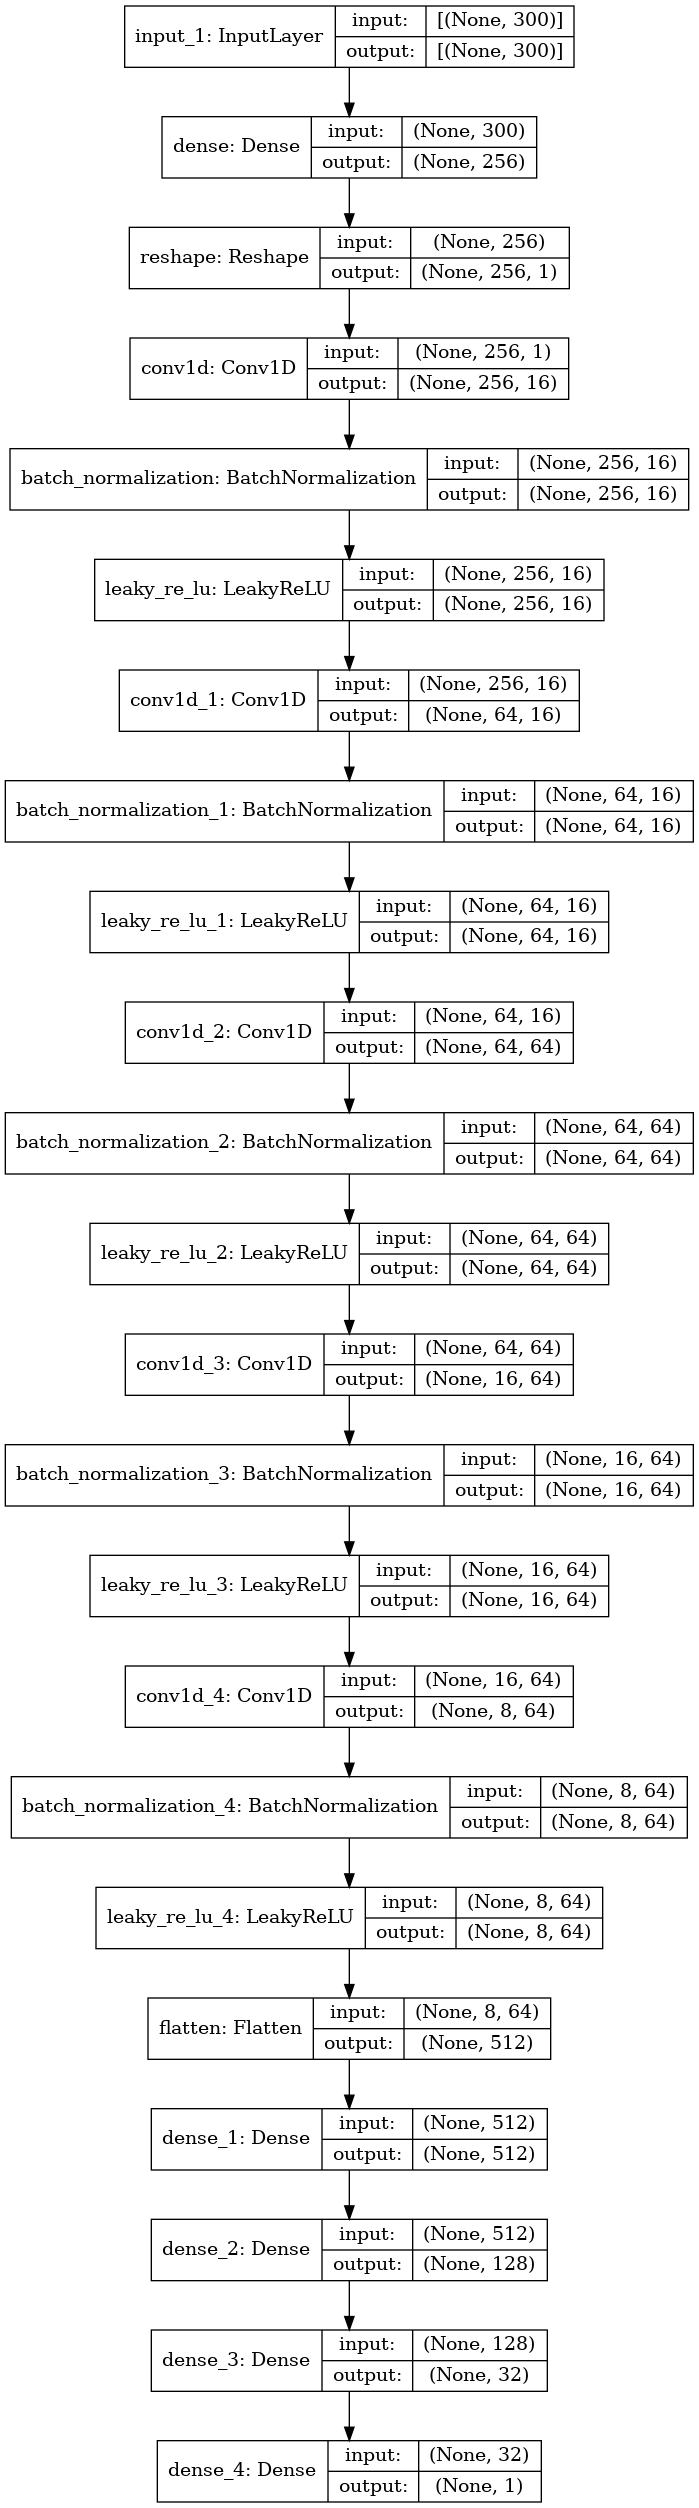

In [6]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Model Training

<PrefetchDataset shapes: ((None, 300), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/30


2022-03-28 12:50:57.222882: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


627/627 [==============================] - 231s 354ms/step - loss: 4.4490 - mse: 0.8331 - mae: 0.6246 - mape: 169883.0000 - rmse: 0.9128 - correlation: 0.8893 - val_loss: 2.0320 - val_mse: 0.8654 - val_mae: 0.6485 - val_mape: 61476.0430 - val_rmse: 0.9303 - val_correlation: 0.9244
Epoch 2/30
627/627 [==============================] - 48s 76ms/step - loss: 1.3348 - mse: 0.8263 - mae: 0.6217 - mape: 151496.7969 - rmse: 0.9090 - correlation: 0.8686 - val_loss: 1.0346 - val_mse: 0.8624 - val_mae: 0.6441 - val_mape: 99524.5234 - val_rmse: 0.9286 - val_correlation: 0.9134
Epoch 3/30
627/627 [==============================] - 48s 76ms/step - loss: 0.9125 - mse: 0.8251 - mae: 0.6212 - mape: 140664.6094 - rmse: 0.9083 - correlation: 0.8623 - val_loss: 0.9000 - val_mse: 0.8617 - val_mae: 0.6431 - val_mape: 113886.2891 - val_rmse: 0.9283 - val_correlation: 0.9099
Epoch 4/30
627/627 [==============================] - 48s 77ms/step - loss: 0.8464 - mse: 0.8239 - mae: 0.6208 - mape: 140854.8750 - rm

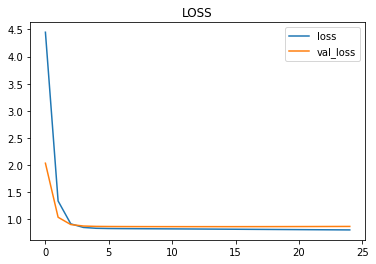

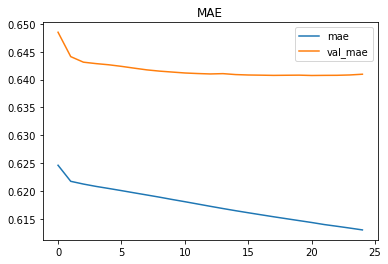

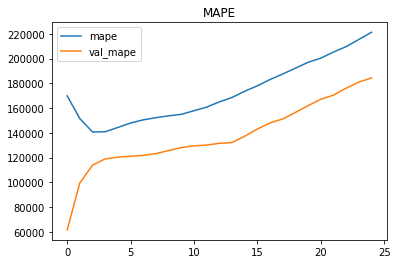

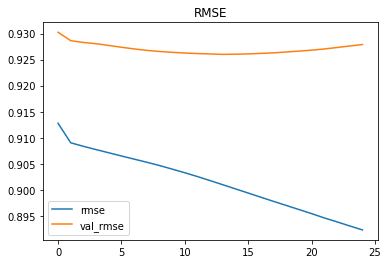

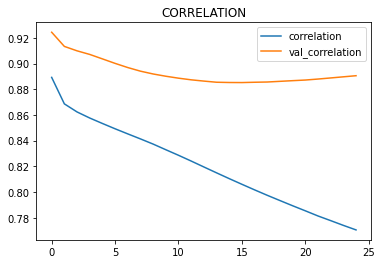

Pearson Score: 0.1151184424696362
<PrefetchDataset shapes: ((None, 300), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/30
637/637 [==============================] - 232s 359ms/step - loss: 4.2902 - mse: 0.8451 - mae: 0.6219 - mape: 163459.0000 - rmse: 0.9193 - correlation: 0.8923 - val_loss: 1.8230 - val_mse: 0.8054 - val_mae: 0.6659 - val_mape: 65445.3711 - val_rmse: 0.8975 - val_correlation: 0.8843
Epoch 2/30
637/637 [==============================] - 49s 78ms/step - loss: 1.2639 - mse: 0.8401 - mae: 0.6196 - mape: 141850.2812 - rmse: 0.9166 - correlation: 0.8775 - val_loss: 0.9359 - val_mse: 0.8025 - val_mae: 0.6630 - val_mape: 85454.1406 - val_rmse: 0.8958 - val_correlation: 0.8771
Epoch 3/30
637/637 [==============================] - 49s 78ms/step - loss: 0.9055 - mse: 0.8387 - mae: 0.6190 - mape: 140842.2812 - rmse: 0.9158 - correlation: 0.8700 - val_loss: 0.8308 - val_mse: 0.8019 - val_mae: 0.6626 - val_mape: 86909.0391 - val_rmse: 0.8955 - val_correlation: 0.8768
Epoch 4/3

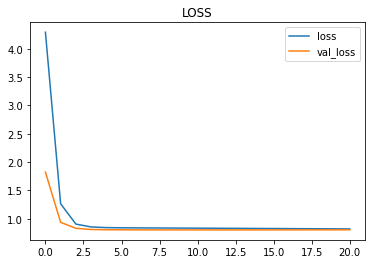

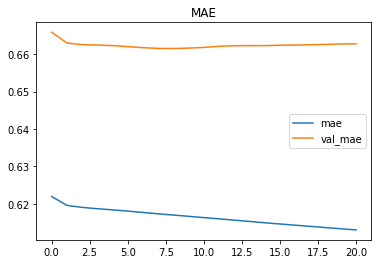

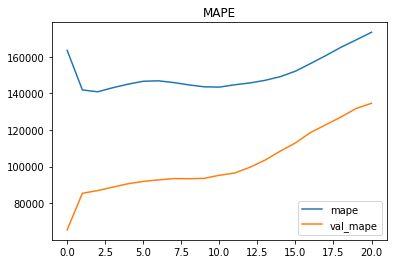

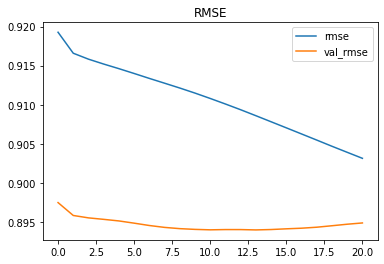

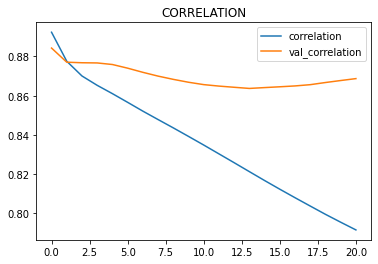

Pearson Score: 0.13717626660815768
<PrefetchDataset shapes: ((None, 300), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/30
611/611 [==============================] - 229s 371ms/step - loss: 4.2591 - mse: 0.8354 - mae: 0.6283 - mape: 165893.1562 - rmse: 0.9140 - correlation: 0.8887 - val_loss: 1.8636 - val_mse: 0.8465 - val_mae: 0.6313 - val_mape: 102808.3281 - val_rmse: 0.9201 - val_correlation: 0.8934
Epoch 2/30
611/611 [==============================] - 48s 78ms/step - loss: 1.2530 - mse: 0.8304 - mae: 0.6260 - mape: 149880.5781 - rmse: 0.9113 - correlation: 0.8718 - val_loss: 0.9751 - val_mse: 0.8441 - val_mae: 0.6281 - val_mape: 146970.0625 - val_rmse: 0.9187 - val_correlation: 0.8875
Epoch 3/30
611/611 [==============================] - 48s 78ms/step - loss: 0.8947 - mse: 0.8290 - mae: 0.6253 - mape: 142025.9844 - rmse: 0.9105 - correlation: 0.8646 - val_loss: 0.8719 - val_mse: 0.8434 - val_mae: 0.6274 - val_mape: 157811.7031 - val_rmse: 0.9184 - val_correlation: 0.8851
Epoch

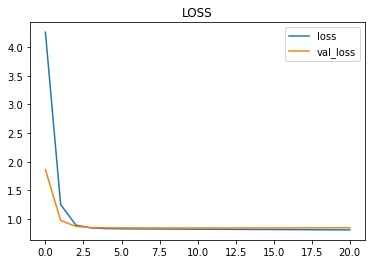

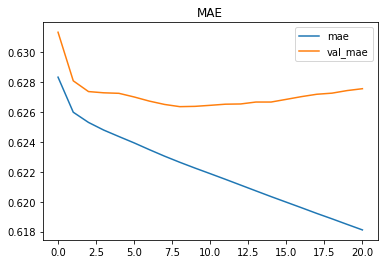

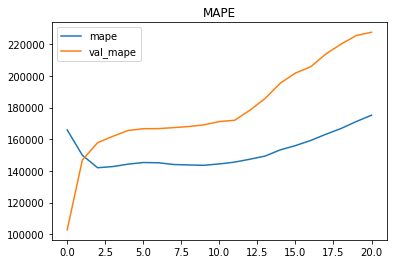

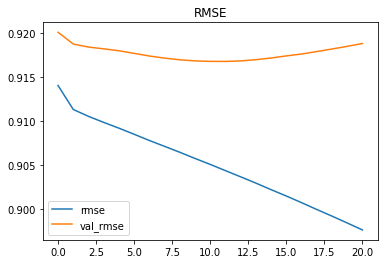

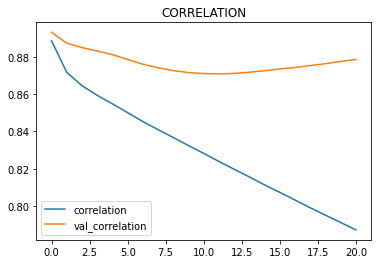

Pearson Score: 0.13015010142149167
<PrefetchDataset shapes: ((None, 300), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/30
584/584 [==============================] - 222s 375ms/step - loss: 4.3646 - mse: 0.8277 - mae: 0.6281 - mape: 136441.2188 - rmse: 0.9098 - correlation: 0.8799 - val_loss: 1.9853 - val_mse: 0.8647 - val_mae: 0.6278 - val_mape: 193692.8594 - val_rmse: 0.9299 - val_correlation: 0.9140
Epoch 2/30
584/584 [==============================] - 45s 78ms/step - loss: 1.3004 - mse: 0.8233 - mae: 0.6259 - mape: 103572.6562 - rmse: 0.9074 - correlation: 0.8663 - val_loss: 1.0144 - val_mse: 0.8627 - val_mae: 0.6248 - val_mape: 324028.3750 - val_rmse: 0.9288 - val_correlation: 0.9064
Epoch 3/30
584/584 [==============================] - 46s 79ms/step - loss: 0.8974 - mse: 0.8216 - mae: 0.6252 - mape: 103642.8750 - rmse: 0.9064 - correlation: 0.8583 - val_loss: 0.8949 - val_mse: 0.8621 - val_mae: 0.6244 - val_mape: 313502.5312 - val_rmse: 0.9285 - val_correlation: 0.9030
Epoch

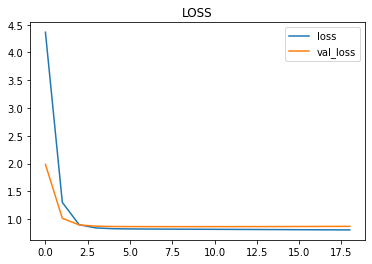

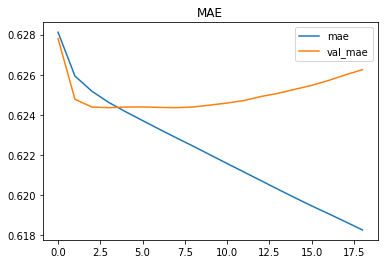

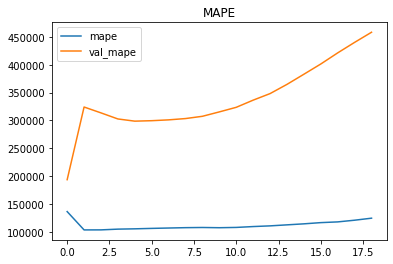

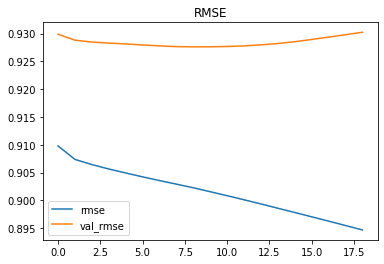

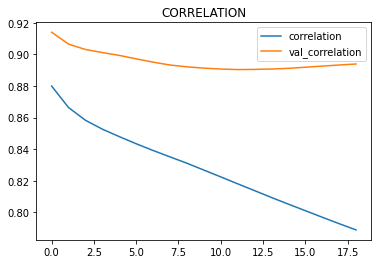

Pearson Score: 0.11039073464303445
<PrefetchDataset shapes: ((None, 300), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/30
577/577 [==============================] - 227s 390ms/step - loss: 4.3562 - mse: 0.8442 - mae: 0.6350 - mape: 170916.6875 - rmse: 0.9188 - correlation: 0.8878 - val_loss: 1.9206 - val_mse: 0.8115 - val_mae: 0.6015 - val_mape: 99569.8828 - val_rmse: 0.9008 - val_correlation: 0.8852
Epoch 2/30
577/577 [==============================] - 45s 78ms/step - loss: 1.3136 - mse: 0.8392 - mae: 0.6326 - mape: 150472.9219 - rmse: 0.9161 - correlation: 0.8692 - val_loss: 0.9648 - val_mse: 0.8110 - val_mae: 0.6009 - val_mape: 82852.4531 - val_rmse: 0.9006 - val_correlation: 0.8824
Epoch 3/30
577/577 [==============================] - 45s 78ms/step - loss: 0.9151 - mse: 0.8374 - mae: 0.6319 - mape: 152091.7344 - rmse: 0.9151 - correlation: 0.8611 - val_loss: 0.8454 - val_mse: 0.8106 - val_mae: 0.6007 - val_mape: 83373.6953 - val_rmse: 0.9004 - val_correlation: 0.8809
Epoch 4/

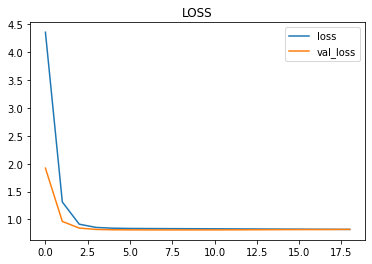

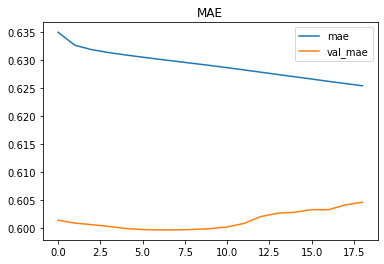

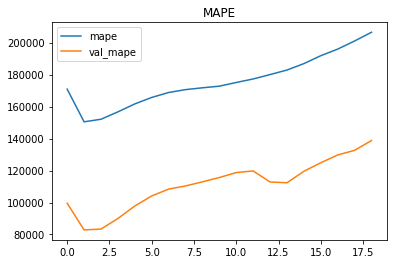

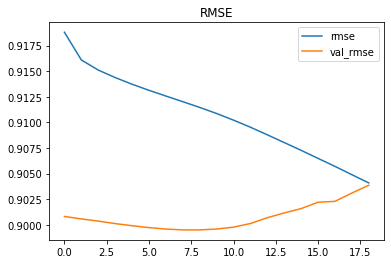

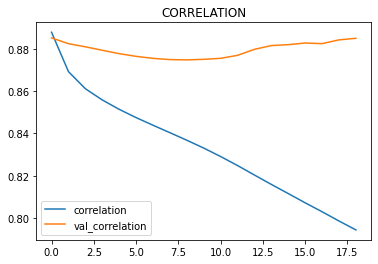

Pearson Score: 0.126874998610582
CPU times: user 1h 29min 57s, sys: 9min, total: 1h 38min 58s
Wall time: 2h 3min 30s


In [7]:
%%time
models = []
for i in range(5):
    train_path = f"{config.tf_record_dataset_path}fold_{i}_train.tfrecords"
    valid_path = f"{config.tf_record_dataset_path}fold_{i}_test.tfrecords"
    valid_ds = make_dataset([valid_path], mode="valid")
    print(valid_ds)
    model = get_model()
    if config.is_training:
        train_ds = make_dataset([train_path])
        checkpoint = keras.callbacks.ModelCheckpoint(f"model_{i}.tf", monitor="val_correlation", mode="min", save_best_only=True, save_weights_only=True)
        early_stop = keras.callbacks.EarlyStopping(patience=10)
        history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
        model.load_weights(f"model_{i}.tf")
        for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
            pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
    else:
        model.load_weights(f"{config.output_dataset_path}model_{i}.tf")
    y_vals = []
    for _, y in valid_ds:
        y_vals += list(y.numpy().reshape(-1))
    y_val = np.array(y_vals)
    pearson_score = stats.pearsonr(model.predict(valid_ds).reshape(-1), y_val)[0]
    models.append(model)
    print(f"Pearson Score: {pearson_score}")


## Submission

In [8]:
def make_test_dataset(feature, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((feature)))
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [9]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
features = [f"f_{i}" for i in range(300)]
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)     

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
